## Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results

### Downloading the data and preprocessing it

In [1]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

# Import with pandas
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

--2023-09-10 16:57:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2023-09-10 16:57:16 (12.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [2]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head() , bitcoin_prices.shape

(                Price
 Date                 
 2013-10-01  123.65499
 2013-10-02  125.45500
 2013-10-03  108.58483
 2013-10-04  118.67466
 2013-10-05  121.33866,
 (2787, 1))

In [3]:
# Get the data in array
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

timesteps= bitcoin_prices.index.to_numpy()
prices=bitcoin_prices['Price'].to_numpy()

#Using minmax scaler to scale
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [4]:
# Create function to view NumPy arrays as windows

def get_labelled_windows(x , horizon):
  return x[:, :-horizon] ,x[: , -horizon:]


def make_windows_scaled(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size. Also applies the standard scaler
  """
  scaler.fit(np.expand_dims(x , axis =1))
  scaled_x = scaler.transform(np.expand_dims(x , axis = 1))
  scaled_x = np.squeeze(scaled_x)

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(scaled_x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = scaled_x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


# Make the splits
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

In [5]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [6]:
# Model 1 (Horizon = 1 , Window_size = 7)
HORIZON = 1
WINDOW_SIZE = 7


full_windows , full_labels = make_windows_scaled(prices , window_size = WINDOW_SIZE , horizon = HORIZON)
full_windows.shape , full_labels.shape

((2780, 7), (2780, 1))

In [7]:
# Looking at few examples of how price is scaled
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}')

Window: [0.00023831 0.00026677 0.         0.00015955 0.00020168 0.00019087
 0.0002089 ] --> Label [0.00022847]
Window: [0.00026677 0.         0.00015955 0.00020168 0.00019087 0.0002089
 0.00022847] --> Label [0.00024454]
Window: [0.         0.00015955 0.00020168 0.00019087 0.0002089  0.00022847
 0.00024454] --> Label [0.00027478]


In [8]:
# Making train and test splits
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [9]:
from keras import optimizers
# Building model 1
tf.random.set_seed(42)

#Construct the model

model_1=tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON,activation='linear')
])

#Compile
model_1.compile(
      loss='mae',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['mae']
)

#Fit the model
model_1.fit(x = train_windows ,
            y = train_labels ,
            epochs = 100 , batch_size = 128,
            validation_data = (test_windows , test_labels))

Epoch 1/100
18/18 [==============================] - 6s 26ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0181 - val_mae: 0.0181
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0026 - val_loss: 0.0179 - val_mae: 0.0179
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0025 - mae: 0.0025 - val_loss: 0.0144 - val_mae: 0.0144
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0025 - mae: 0.0025 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0023 

In [10]:
# Evaluate the model on test data
model_1.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 0.0136 - mae: 0.0136


[0.013593130744993687, 0.013593130744993687]

In [11]:
# Making predictions
model_1_preds = tf.squeeze(model_1.predict(test_windows))

18/18 [==============================] - 0s 3ms/step


Now doing the same for the Multivariate data especially for the Model 6

In [12]:
# Block reward values
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [13]:

# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [14]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [15]:
# Scaling the X data
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.expand_dims(y , axis = 1))
y_scaled = np.squeeze(y_scaled)

In [16]:
# Make train and test set splits of the scaled data
split_size = int(len(X) * 0.8)
X_train, y_train = X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test = X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [17]:

# Building a Multivariate time series model and fitting it
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128 , activation= 'relu'),
  layers.Dense(HORIZON)
])

model_6.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_6.fit(X_train , y_train ,
          epochs = 100 ,
           batch_size = 128,
          validation_data = (X_test , y_test))

Epoch 1/100
18/18 [==============================] - 2s 16ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.1404 - val_mae: 0.1404
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0051 - mae: 0.0051 - val_loss: 0.1144 - val_mae: 0.1144
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0034 - mae: 0.0034 - val_loss: 0.1193 - val_mae: 0.1193
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0027 - mae: 0.0027 - val_loss: 0.1103 - val_mae: 0.1103
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0027 - val_loss: 0.1059 - val_mae: 0.1059
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0029 - mae: 0.0029 - val_loss: 0.1086 - val_mae: 0.1086
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0027 - mae: 0.0027 - val_loss: 0.1062 - val_mae: 0.1062
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0028 - 

In [18]:
# Evaluate the model 6
model_6.evaluate(X_test , y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0931 - mae: 0.0931


[0.09310214221477509, 0.09310214221477509]

## 3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?

* Setup a series of experiments to find whether or not there’s a better window size.
* For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

In [19]:
# Writing a evaluation function based on the preds and targets
def evaluate_preds(y_true , y_pred):

  # Casting the values to float32
  y_true = tf.cast(y_true , tf.float32)
  y_pred = tf.cast(y_pred , tf.float32)


  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true , y_pred)

  # For longer horizons
  if mae.ndim > 0:
    mae = tf.reduce_sum(mae)
    mse = tf.reduce_sum(mse)
    rmse = tf.reduce_sum(rmse)
    mape = tf.reduce_sum(mape)

  return {'mae' : mae.numpy() ,
          'mse': mse.numpy() ,
          'rmse': rmse.numpy() ,
          'mape': mape.numpy() }


In [20]:
# Writing a for loop to iterate over the Window size and build 10 different models

# 10 Different models with window size ranging from (2 - 12) and store the results
model_results_list = []

from tqdm import tqdm
for size in tqdm(range(2,12)):
  HORIZON = 1
  WINDOW_SIZE = size

  # Making window and labels
  full_windows , full_labels = make_windows_scaled(prices, window_size= WINDOW_SIZE , horizon= HORIZON)


  # Splitting the data in train and test
  train_windows ,  test_windows ,train_labels,  test_labels = make_train_test_splits(full_windows , full_labels)


  # Building a simple dense model
  input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer')
  x = layers.Dense(128 , activation= 'relu')(input)
  output = layers.Dense(HORIZON , activation= 'linear')(x)

  # Packing into a model
  model = tf.keras.Model(input , output , name = f'model_windowed_{size}')
  model_window_size=f'model_windowed_{size}'
  # Compiling and fitting the model
  model.compile(loss = 'mae' , optimizer = 'adam' , metrics = 'mae')

  model.fit(train_windows , train_labels ,
            epochs = 100 , verbose = 0 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_labels))


  # Making predictions
  preds_ = model.predict(test_windows)
  y_preds = tf.squeeze(preds_)

  results = evaluate_preds(tf.squeeze(test_labels) , y_preds)
  model_results_list.append([model_window_size,results])

  0%|          | 0/10 [00:00<?, ?it/s]

18/18 [==============================] - 0s 2ms/step


 10%|█         | 1/10 [00:09<01:27,  9.74s/it]

18/18 [==============================] - 0s 2ms/step


 20%|██        | 2/10 [00:20<01:23, 10.38s/it]

18/18 [==============================] - 0s 2ms/step


 30%|███       | 3/10 [00:29<01:07,  9.60s/it]

18/18 [==============================] - 0s 2ms/step


 40%|████      | 4/10 [00:40<01:00, 10.11s/it]

18/18 [==============================] - 0s 2ms/step


 50%|█████     | 5/10 [00:49<00:48,  9.79s/it]

18/18 [==============================] - 0s 2ms/step


 60%|██████    | 6/10 [01:00<00:40, 10.21s/it]

18/18 [==============================] - 0s 2ms/step


 70%|███████   | 7/10 [01:09<00:29,  9.91s/it]

18/18 [==============================] - 0s 2ms/step


 80%|████████  | 8/10 [01:18<00:19,  9.52s/it]

18/18 [==============================] - 0s 2ms/step


 90%|█████████ | 9/10 [01:29<00:09,  9.99s/it]

18/18 [==============================] - 0s 2ms/step


100%|██████████| 10/10 [01:38<00:00,  9.87s/it]


In [21]:
# Below are the 10 different models result
model_results_list

[['model_windowed_2',
  {'mae': 0.020046094,
   'mse': 0.0014157933,
   'rmse': 0.037627026,
   'mape': 4.08735}],
 ['model_windowed_3',
  {'mae': 0.02660994,
   'mse': 0.0025775724,
   'rmse': 0.0507698,
   'mape': 4.847013}],
 ['model_windowed_4',
  {'mae': 0.014506415,
   'mse': 0.000753568,
   'rmse': 0.027451193,
   'mape': 3.289538}],
 ['model_windowed_5',
  {'mae': 0.015792063,
   'mse': 0.00087734056,
   'rmse': 0.029619936,
   'mape': 3.535445}],
 ['model_windowed_6',
  {'mae': 0.012336386,
   'mse': 0.0005153265,
   'rmse': 0.022700803,
   'mape': 3.1303864}],
 ['model_windowed_7',
  {'mae': 0.011987914,
   'mse': 0.00051064347,
   'rmse': 0.022597423,
   'mape': 2.9993799}],
 ['model_windowed_8',
  {'mae': 0.01151207,
   'mse': 0.0004477473,
   'rmse': 0.02116004,
   'mape': 2.9858856}],
 ['model_windowed_9',
  {'mae': 0.012587333,
   'mse': 0.0004636923,
   'rmse': 0.021533515,
   'mape': 3.4941149}],
 ['model_windowed_10',
  {'mae': 0.010030561,
   'mse': 0.0003336018,
   

### 4. Create a windowed dataset just like the ones we used for model_1 using tf.keras.preprocessing.timeseries_dataset_from_array() and retrain model_1 using the recreated dataset

In [22]:
WINDOW_SIZE = 7
HORIZON = 1


In [23]:
# Make the splits
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

In [24]:

ds = tf.keras.utils.timeseries_dataset_from_array(
    data = prices , targets = prices , sequence_length = WINDOW_SIZE , sequence_stride = HORIZON,
    batch_size = 128
)

In [25]:
train_size , test_size = int(0.8 * len(ds)) ,int(0.2 * len(ds))

In [26]:
train_ds = ds.take(train_size)
test_ds = ds.skip(train_size).take(test_size)

In [27]:
for x , y in train_ds.take(1):
  print(x[:2] , y[:2])

tf.Tensor(
[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]], shape=(2, 7), dtype=float64) tf.Tensor([123.65499 125.455  ], shape=(2,), dtype=float64)


In [28]:
# Building the Model 1 with the updated data
tf.random.set_seed(42)

# Building a simple dense model
input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer' , dtype = tf.float32)
x = layers.Dense(128 , activation= 'relu')(input)
output = layers.Dense(HORIZON , activation= 'linear')(x)

# Packing into a model
model = tf.keras.Model(input , output)

# Compiling the model
model.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['mae'])

# Fit the model
model.fit(train_ds ,
          epochs = 100 , verbose = 1 ,
            validation_data = test_ds)

Epoch 1/100
17/17 [==============================] - 1s 39ms/step - loss: 971.4052 - mae: 971.4052 - val_loss: 800.2886 - val_mae: 800.2886
Epoch 2/100
17/17 [==============================] - 1s 38ms/step - loss: 747.6090 - mae: 747.6090 - val_loss: 1845.2452 - val_mae: 1845.2452
Epoch 3/100
17/17 [==============================] - 1s 37ms/step - loss: 298.9892 - mae: 298.9892 - val_loss: 323.8755 - val_mae: 323.8755
Epoch 4/100
17/17 [==============================] - 1s 34ms/step - loss: 438.0863 - mae: 438.0863 - val_loss: 569.4258 - val_mae: 569.4258
Epoch 5/100
17/17 [==============================] - 1s 55ms/step - loss: 509.9607 - mae: 509.9607 - val_loss: 859.4625 - val_mae: 859.4625
Epoch 6/100
17/17 [==============================] - 1s 54ms/step - loss: 374.0346 - mae: 374.0346 - val_loss: 492.1101 - val_mae: 492.1101
Epoch 7/100
17/17 [==============================] - 1s 37ms/step - loss: 465.1788 - mae: 465.1788 - val_loss: 689.3571 - val_mae: 689.3571
Epoch 8/100
17/17 

In [29]:
# Evaluating the model on the test set
model.evaluate(test_ds)

4/4 [==============================] - 0s 16ms/step - loss: 452.2750 - mae: 452.2750


[452.2750244140625, 452.2750244140625]

5. **For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
Are there any other features you think you could add?**  
If so, try it out, how do these affect the model?

In [30]:
df


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [31]:
import datetime


In [32]:

# Creating a day of week feature
df['day_of_week'] = df.index.dayofweek
df.head(10)


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),day_of_week
Date,,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349,1
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383,2
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833,3
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816,4
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566,5
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450,6
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199,0
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066,1
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266,2


In [33]:
# Defining the hyper parameters
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed['day_of_week'] = bitcoin_prices_windowed.index.dayofweek

In [34]:
# Getting three kinds of data (univariate , multivariate and the day of week)

# Univariate data
full_windows , full_labels = make_windows_scaled(prices)
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)

# Multivaritate data
X = bitcoin_prices_windowed.dropna().drop('Price' , axis = 1).astype(np.float32)
X_scaled = scaler.fit_transform(X)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

# Day of week
day_of_week = bitcoin_prices_windowed.dropna()['day_of_week'].to_list()

In [35]:
# Checking the shapes
print(full_windows.shape , full_labels.shape)
print(X.shape , y.shape)
print(len(day_of_week))

(2780, 7) (2780, 1)
(2780, 9) (2780,)
2780


In [36]:
# Splitting the multivariate and the day_of_week to train and test splits
split_size = int(len(X) * 0.8)
train_block_rewards , test_block_rewards = X[:split_size] , X[split_size:]
train_days , test_days = day_of_week[:split_size] , day_of_week[split_size:]

len(train_block_rewards), len(train_days) , len(test_block_rewards) , len(test_days)

(2224, 2224, 556, 556)

In [42]:
train_block_rewards.head(2)

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,day_of_week
Date,,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991,1.0
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,2.0


In [44]:
train_windows[0]

array([0.00023831, 0.00026677, 0.        , 0.00015955, 0.00020168,
       0.00019087, 0.0002089 ])

In [46]:
train_days[:7]

[1, 2, 3, 4, 5, 6, 0]

In [47]:
# Building a performant dataset for train and test

train_data_tribid = tf.data.Dataset.from_tensor_slices((train_windows ,
                                                        train_block_rewards ,
                                                        train_days))

train_labels_tribid = tf.data.Dataset.from_tensor_slices(train_labels)

# The test/val split
test_data_tribid = tf.data.Dataset.from_tensor_slices((test_windows ,
                                                       test_block_rewards ,
                                                       test_days))

test_labels_tribid = tf.data.Dataset.from_tensor_slices(test_labels)

# Zipping the data and labels into one complete dataset
tribid_train_ds = tf.data.Dataset.zip((train_data_tribid , train_labels_tribid))
tribid_test_ds = tf.data.Dataset.zip((test_data_tribid , test_labels_tribid))

# Applying prefetch and batching the dataset
tribid_train_ds = tribid_train_ds.batch(128).prefetch(tf.data.AUTOTUNE)
tribid_test_ds = tribid_test_ds.batch(128).prefetch(tf.data.AUTOTUNE)

tribid_train_ds ,tribid_test_ds


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [48]:
# Building a tribid model

input_windows = layers.Input(shape = (7,) , dtype=tf.float64 , name='Window Inputs')
exp_layer_1 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_windows)
conv1 = layers.Conv1D(filters= 32 , kernel_size=5 , padding='causal' , activation= 'relu')(exp_layer_1)
window_model = tf.keras.Model(input_windows , conv1 , name = 'Windowed model')

input_blocks = layers.Input(shape = (9,) , dtype= tf.float32 , name ='Block rewards input')
exp_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_blocks)
conv2 = layers.Conv1D(filters = 32 , kernel_size= 5 , activation= 'relu' , padding = 'causal')(exp_layer_2)
block_model = tf.keras.Model(input_blocks , conv2 , name = 'Block rewards model')


# Use expand dims to match the same shape output (None , 1 , 128)
# whereas without expand dims it would be (None , 128)
input_days = layers.Input(shape= (1,) , dtype = tf.int32 , name ='Days of week Input')
exp_layer_3 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_days)
dense = layers.Dense(128 , activation= 'relu')(exp_layer_3)
days_model = tf.keras.Model(input_days , dense , name = 'Days Model')

# Concatenating the inputs
concat = layers.Concatenate(name = 'combined_outputs' )([window_model.output ,
                                                           block_model.output ,
                                                           days_model.output])

# Creating the output layer
dropout = layers.Dropout(0.4)(concat)
output_layer = layers.Dense(1 , activation = 'linear')(dropout)

# Putting everything into a model
tribid_model = tf.keras.Model(inputs = [window_model.input ,
                                        block_model.input ,
                                        days_model.input] ,
                              outputs = output_layer)
tribid_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Window Inputs (InputLayer)  [(None, 7)]                  0         []                            
                                                                                                  
 Block rewards input (Input  [(None, 9)]                  0         []                            
 Layer)                                                                                           
                                                                                                  
 Days of week Input (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                            

In [49]:

# Compiling and fitting the model
tribid_model.compile(loss = 'mae' ,
                     optimizer = 'adam' , metrics = ['mae'])

# Fitting the model
tribid_model.fit(tribid_train_ds ,
                 epochs = 20,
                 validation_data = tribid_test_ds , verbose = 2)

Epoch 1/20
18/18 - 7s - loss: 289.8662 - mae: 289.8662 - val_loss: 82.4327 - val_mae: 82.4327 - 7s/epoch - 389ms/step
Epoch 2/20
18/18 - 0s - loss: 204.8862 - mae: 204.8862 - val_loss: 120.3583 - val_mae: 120.3583 - 96ms/epoch - 5ms/step
Epoch 3/20
18/18 - 0s - loss: 139.2165 - mae: 139.2165 - val_loss: 65.0092 - val_mae: 65.0092 - 114ms/epoch - 6ms/step
Epoch 4/20
18/18 - 0s - loss: 100.7858 - mae: 100.7858 - val_loss: 111.6320 - val_mae: 111.6320 - 90ms/epoch - 5ms/step
Epoch 5/20
18/18 - 0s - loss: 59.8736 - mae: 59.8736 - val_loss: 106.4290 - val_mae: 106.4290 - 99ms/epoch - 6ms/step
Epoch 6/20
18/18 - 0s - loss: 34.3466 - mae: 34.3466 - val_loss: 31.9039 - val_mae: 31.9039 - 106ms/epoch - 6ms/step
Epoch 7/20
18/18 - 0s - loss: 13.6581 - mae: 13.6581 - val_loss: 22.3414 - val_mae: 22.3414 - 115ms/epoch - 6ms/step
Epoch 8/20
18/18 - 0s - loss: 2.2817 - mae: 2.2817 - val_loss: 1.3593 - val_mae: 1.3593 - 98ms/epoch - 5ms/step
Epoch 9/20
18/18 - 0s - loss: 0.5567 - mae: 0.5567 - val_lo

In [50]:

# Evaluating the model
tribid_model.evaluate(tribid_test_ds)

5/5 [==============================] - 0s 5ms/step - loss: 0.1474 - mae: 0.1474


[0.14743201434612274, 0.14743201434612274]

6. **Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.**

**Things to do**

* Train an ensemble model on the whole data.
* Make one dataset (no test/valid) which will use to predict future forecasts of bitcoins.
* Make a function that will take the number of iterations and different loss functions to train the model with.

In [51]:
# Make one whole dataset (with the updated bitcoin prices 2014 - 2021)

X_all = bitcoin_prices_windowed.drop(['Price' , 'block_reward' , 'day_of_week'] , axis = 1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

whole_ds = tf.data.Dataset.from_tensor_slices((X_all , y_all))
whole_ds = whole_ds.batch(128).prefetch(tf.data.AUTOTUNE)
whole_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [52]:

# Creating the function

def get_ensemble_models(horizon = HORIZON ,
                        dataset = whole_ds ,
                        num_iter = 10 ,
                        num_epochs = 100 ,
                        loss_fns = ['mae' , 'mse' , 'mape']):


  # Make a empty list of the ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss functions
  for i in range(num_iter):
    for loss_functions in loss_fns:
      print(f'Optimizing model by reducing: {loss_functions} for {num_epochs} epochs, model number: {i}')

      model = tf.keras.Sequential([
          layers.Dense(128 , kernel_initializer='he_normal' , activation= 'relu'),
          layers.Dense(128 , kernel_initializer= 'he_normal', activation= 'relu'),
          layers.Dense(HORIZON)
      ])

      # Compiling the model
      model.compile(loss = loss_functions ,
                    optimizer = 'adam' , metrics = ['mae' , 'mse'])

      # Fit the model
      model.fit(dataset ,
                epochs = num_epochs ,
                verbose = 0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                                                patience=100,
                                                                verbose=1)])

      ensemble_models.append(model)

  return ensemble_models

In [53]:
# Running the above function
ensemble_models = get_ensemble_models(num_iter=5 , num_epochs= 1000 , horizon = 1)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 445: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 588: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 218: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 517: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 154: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 255: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 357: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 195: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 363: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing 

In [54]:

# Making future forecastts of Bitcoins (using the whole data)
def make_future_forecast(values , model_list , into_future , window_size):

  future_forecast = []
  last_window = values[-window_size:]

  for _ in range(into_future):
    for model in model_list:

      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())

      # Update the last window
      last_window = np.append(last_window , future_pred)[-window_size:]
  return future_forecast

In [55]:
# Getting the future forecast
future_forecast = make_future_forecast(y_all , ensemble_models , into_future= 14 , window_size = 7 )

1/1 [==============================] - 0s 51ms/step
Predicing on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] --> Prediction: 56348.49609375

1/1 [==============================] - 0s 53ms/step
Predicing on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56348.49609375] --> Prediction: 51352.05859375

1/1 [==============================] - 0s 67ms/step
Predicing on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56348.49609375 51352.05859375] --> Prediction: 49207.79296875



1/1 [==============================] - 0s 67ms/step
Predicing on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56348.49609375 51352.05859375 49207.79296875] --> Prediction: 51789.08984375



1/1 [==============================] - 0s 61ms/step
Predicing on: 
 [47885.62525472 45604.61575361 43144.47129086 56348.49609375
 51352.05859375 49207.79296875 51789.08984375] --> Prediction: 47833.796875

1/1 [==============================] - 0s 61ms/step
Predicing on: 
 [45604.61575361 43144.47129086 56348.49609375 51352.05859375
 49207.79296875 51789.08984375 47833.796875  ] --> Prediction: 46097.32421875

1/1 [==============================] - 0s 56ms/step
Predicing on: 
 [43144.47129086 56348.49609375 51352.05859375 49207.79296875
 51789.08984375 47833.796875   46097.32421875] --> Prediction: 45000.84765625

1/1 [==============================] - 0s 61ms/step
Predicing on: 
 [56348.49609375 51352.05859375 49207.79296875 51789.08984375
 47833.796875   46097.32421875 45000.84765625] --> Prediction: 55845.7890625

1/1 [==============================] - 0s 64ms/step
Predicing on: 
 [51352.05859375 49207.79296875 51789.08984375 47833.796875
 46097.32421875 45000.84765625 55845.7890625

**7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn’t retrained for every forecast (model_9)?**
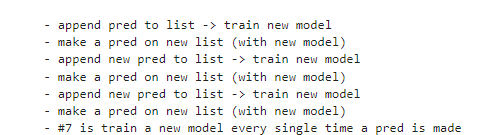


In [56]:
# Lets code things at first without a loop and see how it foes
HORIZON = 1
WINDOW_SIZE = 7

# Building a model (You can replace it with any model)
def get_model(horizon = HORIZON):
    model = tf.keras.Sequential([
            layers.Dense(128 , activation = 'relu'),
            layers.Dense(128 , activation = 'relu'),
            layers.Dense(horizon)
        ])

    model.compile(loss = tf.keras.losses.mae ,
                  optimizer = tf.keras.optimizers.Adam())


    return model

In [57]:
#. Making the data and labels for window size of 7 and horizon of 1
full_windows , full_labels = make_windows(prices , window_size= WINDOW_SIZE , horizon= HORIZON)

In [58]:
# Making future forecastts of Bitcoins (using the whole data)
def pred_model_run(values , X, model , into_future , window_size  , horizon, epochs ):

  '''
  This function train a model for every updated predictions.

  Arguments:
  ----------
      - values --> labels / truth values. Bitcoin prices
      - X --> Windowed data of the bitcoin prices (default window size is 7)
      - model --> compiled model with default horizon 1
      - into_future -->  how many time steps to predict in the future?
      - window_size --> default is 7 (using the 7 days prices of bitcoin)
      - horizon --> default is 1 (predicting the price of next day)

  Returns:
  --------
      - model --> a model that has been trained on all the previous predictions + the data
  '''

  last_window = values[-window_size:]
  X_all = X
  y_all = values
  for _ in range(into_future):

      # Each time the model is trained for 5 epochs with the updated data
      model.fit(x = X_all , y = y_all , epochs = epochs , verbose = 0)

      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())
      #values = np.append(values , tf.squeeze(future_pred).numpy())
      for i in range(0 , len(X_all)):
        x = X_all[i][1:]  # removing the 0th index of the X window ()
        y = y_all[1:] # removing the 0th index  of y
        X = np.append(x , future_pred) # append the future pred at last to X window
        values = np.append(y , future_pred) # appending the future pred to y

      # Update the last window
      last_window = np.append(last_window , future_pred)[-window_size:]


  return model


In [59]:
full_windows.shape , X_all.shape , full_labels.shape , y_all.shape

((2780, 7), (2780, 7), (2780, 1), (2780,))

In [60]:
# Using the above function
trained_model = pred_model_run(values = tf.squeeze(full_labels) ,
                               X = full_windows ,
                               model = get_model(horizon = 1) ,
                               window_size = WINDOW_SIZE ,
                               horizon = HORIZON ,
                               epochs = 10 ,
                               into_future  =14 )

1/1 [==============================] - 0s 54ms/step
Predicing on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] --> Prediction: 45143.08984375

1/1 [==============================] - 0s 19ms/step
Predicing on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 45143.08984375] --> Prediction: 43646.16796875

1/1 [==============================] - 0s 26ms/step
Predicing on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 45143.08984375 43646.16796875] --> Prediction: 43399.1796875

1/1 [==============================] - 0s 22ms/step
Predicing on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 45143.08984375 43646.16796875 43399.1796875 ] --> Prediction: 42172.43359375

1/1 [==============================] - 0s 18ms/step
Predicing on: 
 [47885.62525472 45604.61575361 43144.47129086 45143.08984375
 43646.16796875 43399.1796875  42172.433

In [61]:
# Trying out new libraries
# Installing facebooks kats lib
pip install kats

SyntaxError: ignored

In [ ]:

# Importing the TimeSerisData class from Kats
from kats.consts import TimeSeriesData


In [ ]:

# Utils to work with Kats
from dateutil import parser
from datetime import datetime

In [ ]:

# Creating a Dataset object with Kats
ts_data = TimeSeriesData(time = bitcoin_prices_updated.index ,
               value = bitcoin_prices_updated.Price)

type(ts_data)


In [ ]:

# Plotting the timeseries data
import matplotlib.pyplot as plt

ts_data.plot(cols=['Price'])
plt.show()

In [ ]:

# Importing the prophet
from kats.models.prophet import ProphetModel , ProphetParams

# Creating a model param instance
params = ProphetParams(seasonality_mode= 'multiplicative')

# Create a prophet model instance (just like how we create an instance in sklearn)
model = ProphetModel(ts_data , params)

# Fitting the model
model.fit()

# Making predictions
forecast = model.predict(steps= 1 , include_history= True , freq = '1W')

In [ ]:
# Predicting the bitcoin price for a day (Horizon = 1 )
forecast.head(10)

In [ ]:
# Importing the things we need
from kats.models.ensemble.ensemble import EnsembleParams , BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters ,
    linear_model ,
    prophet ,
    quadratic_model ,
    sarima ,
    theta
)

In [ ]:

# Defining the parameters of different models
model_params = EnsembleParams(
    [
     BaseModelParams('arima' , arima.ARIMAParams(p = 1 , d=1 , q=1)) ,
     BaseModelParams('sarima' ,
                     sarima.SARIMAParams(
                         p = 2 , d= 2 , q =1 , trend = 'ct' ,
                     seasonal_order = (1, 0 ,1 ,12) , enforce_invertibility = False ,
                     enforce_stationarity = False),
     ),
     BaseModelParams('prophet' , prophet.ProphetParams()) ,
     BaseModelParams('linear' , linear_model.LinearModelParams()) ,
     BaseModelParams('quadratic' , quadratic_model.QuadraticModelParams()),
     BaseModelParams('theta' , theta.ThetaParams()),
    ]
)

In [ ]:

# Creating KatEnsembleParam with detailed configuration
KatEnsembleParams = {
    'models': model_params ,
    'aggregation': 'median' ,
    'seasonality_length': 7 ,
    'decomposition_method': 'multiplicative'
}

In [ ]:

# Creating a Time Series dataset
bitcoin_ts = TimeSeriesData(value = bitcoin_prices.Price,
                            time = bitcoin_prices.index ,
                            sort_by_time= True)


In [ ]:

# Creating a KatEnsemble model (or) instantiating it
ensemble_model = KatsEnsemble(
    data = bitcoin_ts ,
    params = KatEnsembleParams
)

# Fitting the model
ensemble_model.fit()

In [ ]:

# Making prediction for the next 30 days
forecast = ensemble_model.predict(steps = 30)

In [ ]:

# Aggregate individual model results (we will get the predictions for 30 Days)
ensemble_model.aggregate()

In [ ]:

# Plotting the model
ensemble_model.plot()